In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
path = "sample_data/"
filename = "Toys_and_Games.csv"

toysngames = pd.read_csv(path + filename, index_col = [0])

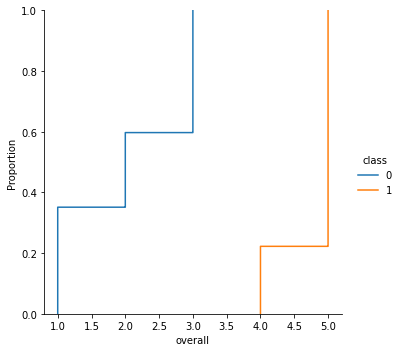

In [34]:
sns.displot(data = toysngames, x="overall", hue = "class", kind = "ecdf")

In [31]:
toysngames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             100000 non-null  object
 1   reviewerID      100000 non-null  object
 2   asin            100000 non-null  object
 3   reviewerName    99489 non-null   object
 4   helpful         100000 non-null  object
 5   reviewText      100000 non-null  object
 6   overall         100000 non-null  int64 
 7   summary         99998 non-null   object
 8   unixReviewTime  100000 non-null  int64 
 9   reviewTime      100000 non-null  object
 10  category        100000 non-null  object
 11  class           100000 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 12.4+ MB


In [36]:
#import modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

#create Spark session
appName = "Sentiment Analysis in Spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [38]:
toysngames = spark.read.csv(path + filename, inferSchema=True, header=True)

In [39]:
data = toysngames.select("summary", col("class").cast("Int").alias("label"))
data.show(truncate = False,n=5)

+------------------------------------------+-----+
|summary                                   |label|
+------------------------------------------+-----+
|Charming characters but busy work required|1    |
|No directions for use...                  |0    |
|Great CD-ROM                              |1    |
|Puzzles                                   |1    |
|Algebra II -- presentation materials      |1    |
+------------------------------------------+-----+
only showing top 5 rows



In [40]:
dividedData = data.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] 
testingData = dividedData[1] 
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)


Training data rows: 70096 ; Testing data rows: 29904


In [42]:
tokenizer = Tokenizer(inputCol="summary", outputCol="summary_words")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=5)

+---------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------+
|summary                                                                                                  |label|summary_words                                                                                                                |
+---------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------+
|  The GAME IS REALLY FUN - it's the product materials with which I have issue."                          |null |[, , the, game, is, really, fun, -, it's, the, product, materials, with, which, i, have, issue."]                            |
| ""Authors"" where in playing the game 

In [43]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=5)

+---------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|summary                                                                                                  |label|summary_words                                                                                                                |MeaningfulWords                                                                                 |
+---------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------

In [44]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=3)

+-----+-------------------------------------------------------+------------------------------------------------------------------------------------------------+
|label|MeaningfulWords                                        |features                                                                                        |
+-----+-------------------------------------------------------+------------------------------------------------------------------------------------------------+
|null |[, , game, really, fun, -, product, materials, issue."]|(262144,[23087,38333,38640,52879,137787,138895,229264,249180],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0])|
|null |[, ""authors"", playing, game]                         |(262144,[138895,219389,249180,252169],[1.0,1.0,1.0,1.0])                                        |
|null |[, ""die, zombies]                                     |(262144,[64005,71888,249180],[1.0,1.0,1.0])                                                     |
+-----+---------------------------

In [51]:
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)

Py4JJavaError: An error occurred while calling o352.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 18.0 failed 1 times, most recent failure: Lost task 7.0 in stage 18.0 (TID 70, 172.20.10.5, executor driver): scala.MatchError: [null,1.0,(262144,[9589,24346,31536,56465,63413,71301,115658,138895,141702,172498,225348,238812,249180],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0])] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$1(Predictor.scala:80)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2194)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:499)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:487)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:482)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:281)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:150)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: scala.MatchError: [null,1.0,(262144,[9589,24346,31536,56465,63413,71301,115658,138895,141702,172498,225348,238812,249180],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0])] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$1(Predictor.scala:80)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
